- **Author:** Aisling Towey
- **Date:** 10th March 2022

# Overview

The dataset used in this analysis contains headlines from the news source ABC over a period of 15 years. It was prepared by Rohit Kulkarni and can be downloaded at https://www.kaggle.com/therohk/million-headlines. In this analysis we will take a sample of ~10000 headlines across all years.
    
This aim of this analysis is to gain an understanding of what kind of headlines have commonly occurred across the 15 years. This dataset is not labelled so we will use UMAP sentence vectors and clustering to achieve this. We will also look at using cosine similarity separately to find similar headlines to a selected headline.

The below article is useful for explaining UMAP sentence exmbeddings and clustering.
https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e

# Install Packages and Import Modules

In [1]:
# !pip install sentence-transformers
# !pip install tqdm
# !pip install pysbd
# !pip install umap-learn
# !pip install hdbscan

In [2]:
import os
import re
import scipy
import random
import sklearn
import pysbd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap
import matplotlib.ticker as mtick
import seaborn as sns
import statistics
from hdbscan import HDBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
tqdm.pandas()
%matplotlib inline

# load in sentence transformer model
model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
# model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aislingtowey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read in Data

As the dataset is large we will take a sample of ~10000 rows to speed things up. We can achieve this using the skiprows parameter in pandas.read_csv().

In [3]:
number_of_samples_in_file = 1195191 
sample_size = 10000
skip_rows = sorted(random.sample(range(1, number_of_samples_in_file),number_of_samples_in_file-sample_size))

data = pd.read_csv('abcnews-date-text.csv', skiprows=skip_rows)
data.reset_index(inplace=True)
data.head()

,index,publish_date,headline_text
0,0,20030219,funds to go to cadell upgrade
1,1,20030219,vff to buy stock feed pellets for fire affected
2,2,20030220,canegrowers hope for late summer rain
3,3,20030220,charvis pays penalty as humphreys earns shock
4,4,20030220,police tax office to fight chop chop trade


Change the headline publish_date to pandas datetime format and separate the year so we can make a plot to check there is a good split of headlines across all years.

<AxesSubplot:xlabel='publish_year'>

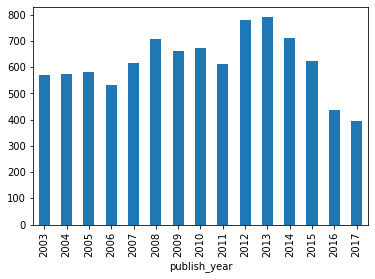

In [4]:
data['publish_date'] = pd.to_datetime(data['publish_date'], format="%Y%m%d") 
data['publish_year'] = data['publish_date'].dt.year
# check there is a good split of headlines across all years
data.groupby('publish_year')['headline_text'].count().plot(kind='bar')

# Get Sentence Embeddings

Now we can encode our headlines to get BERT sentence embeddings using the sentence-transformers package. This can take a little bit of time. BERT sentence embeddings provide contextual embeddings which can be compared using cosine similarity.

In [5]:
# get sentence embeddings
data["headline_sentence_embedding"] = data.progress_apply(
    lambda row: model.encode(row["headline_text"].lower().strip()), axis=1
)
data.head()

  0%|          | 0/9273 [00:00<?, ?it/s]

,index,publish_date,headline_text,publish_year,headline_sentence_embedding
0,0,2003-02-19,funds to go to cadell upgrade,2003,"[0.016798632, 0.015279964, 0.011456677, 0.0313..."
1,1,2003-02-19,vff to buy stock feed pellets for fire affected,2003,"[0.06204204, 0.025440408, 0.02062668, 0.031247..."
2,2,2003-02-20,canegrowers hope for late summer rain,2003,"[0.048719376, -0.0063352603, -0.010003895, -0...."
3,3,2003-02-20,charvis pays penalty as humphreys earns shock,2003,"[0.027937012, 0.015759809, 0.014945172, -0.004..."
4,4,2003-02-20,police tax office to fight chop chop trade,2003,"[0.07559748, 0.01956016, 0.07115385, -0.000681..."


These sentence embeddings have 512 dimensions. We want to reduce the dimensionality to increase speed, reduce vector storage requirements and also to avoid to curse of dimensionality. Distance measures can become ineffective with high dimensionality meaning lower dimensional embeddings would work better for our clustering. We will use UMAP to reduce the number of dimensions in our sentence embeddings. See an explanation of UMAP here: https://pair-code.github.io/understanding-umap/

In [6]:
# get umap embeddings, may need to try a few different values for n_neighbours and n_components
umap_embedder = umap.UMAP(
        n_neighbors=15, 
        n_components=5, # the final dimension of our embeddings
        min_dist=0.0,
        metric="cosine",
        random_state=1
    ).fit(list(data["headline_sentence_embedding"]))

umap_embeddings = umap_embedder.transform(list(data["headline_sentence_embedding"]))
data['umap_embeddings'] = umap_embeddings.tolist()

Our embeddings are now 5D after using UMAP.

# Cluster Headlines (Sentence Embeddings)

Now we will cluster our UMAP embeddings using HDBSCAN. We are using a density based algorithm so we don't need to specify the number of clusters before clustering. HDBSCAN is less prone to noise than DBSCAN as it focuses on high density clustering.

In [7]:
# cluster embeddings using HDBSCAN, again may need to try different hyperparameters
clusters = HDBSCAN(
    min_cluster_size = 15,
    cluster_selection_epsilon=0.1,
    metric='euclidean', 
    cluster_selection_method='eom'
).fit(np.array(list(data["umap_embeddings"])))

data['cluster'] = list(clusters.labels_)
print(f"Number of samples: {len(data)}")
print(f"Number of clusters: {data['cluster'].nunique()}")
print(f"Number of unclustered samples: {len(data.loc[data['cluster']==-1])}")

Number of samples: 9273
Number of clusters: 125
Number of unclustered samples: 3751


Not all samples have to be assigned to a cluster in HDBSCAN and samples that are not in dense regions are assigned to the cluster -1. There are a lot of samples in the -1 (unclassified) cluster. We could reduce the min_cluster_size to 1 to ensure each sample was clustered but we would be left with a lot of clusters with one sample which would not be very useful. Instead we will keep the clusters HDBSCAN finds and use KNN to assign all of the remaining samples to their nearest HDBSCAN cluster so that each headline belongs to a cluster. This is not always necessary as it can create noise in the clusters but for the purpose of this analysis we will cluster all samples.

In [8]:
# split into clustered and unclustered 
clustered_data = data.loc[data["cluster"] != -1]
unclustered_data = data.loc[data["cluster"] == -1]

# fit knn
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(list(clustered_data["umap_embeddings"]), clustered_data["cluster"])

# now get predictions on unclustered data to assign to their nearest cluster
predictions = knn.predict(list(unclustered_data["umap_embeddings"]))
unclustered_data["final_cluster"] = predictions
clustered_data["final_cluster"] = clustered_data["cluster"]

# combine clustered and unclustered data again
final_df = pd.concat([clustered_data, unclustered_data])
final_df = final_df.rename(columns = {'cluster':'original_cluster'})

# now we can see there are no unclustered samples remaining 
print(f"Number of samples: {len(final_df)}")
print(f"Number of clusters: {final_df['final_cluster'].nunique()}")
print(f"Number of unclustered samples: {len(final_df.loc[final_df['final_cluster']==-1])}")

Number of samples: 9273
Number of clusters: 124
Number of unclustered samples: 0


/var/folders/8t/1zx0353571b5rmkj2484dpdw0000gn/T/ipykernel_71893/3579424009.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclustered_data["final_cluster"] = predictions
/var/folders/8t/1zx0353571b5rmkj2484dpdw0000gn/T/ipykernel_71893/3579424009.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_data["final_cluster"] = clustered_data["cluster"]


# Get Cluster Names and Summarize Clusters

It is useful to try and name our clusters so we have a rough idea what they are about rather than reading through all samples in each cluster to figure this out. We will use the most common bigram in each cluster to achieve this.

In [9]:
def get_cluster_name(cluster_text):
    """
    Labels a cluster with a bigram based on the most common bigram in the cluster corpus
    """
    
    # remove numbers
    cluster_text = [re.sub(r"[0-9]", "", sentence) for sentence in cluster_text] 
    vectorizer = CountVectorizer(
        binary=True, 
        stop_words=stopwords, 
        ngram_range=(2, 2)
    )
    
    # get the count of bigrams in our cluster corpus
    tdm = vectorizer.fit_transform(cluster_text)
    # # to view tdm
    # count_array = tdm.toarray()
    # count_df = pd.DataFrame(data=count_array, columns = vectorizer.get_feature_names())
    most_common_bigram_index = np.argmax(tdm.sum(axis=0))
    # assign the cluster the most common bigram
    cluster_keyword = vectorizer.get_feature_names()[most_common_bigram_index]
    
    return cluster_keyword

In [10]:
# now lets get use the get_cluster_name function to name all clusters in our analysis
cluster_keywords = []
for cluster in tqdm(list(final_df["final_cluster"].drop_duplicates())):
    vectorizer = CountVectorizer(binary=True, stop_words=stopwords, ngram_range=(5, 6))
    cluster_text = list(final_df.loc[(final_df["final_cluster"] == cluster),  "headline_text"])
    cluster_name = get_cluster_name(cluster_text)
    cluster_keywords.append({"final_cluster": cluster, "cluster_keyword": cluster_name})
    
cluster_keywords = pd.DataFrame(cluster_keywords)
final_df = final_df.merge(cluster_keywords, on='final_cluster')

  0%|          | 0/124 [00:00<?, ?it/s]

/Users/aislingtowey/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Now that the custers are named let's tidy up or data so we can see the final results.

In [11]:
cluster_summary = final_df.drop_duplicates(subset=["final_cluster", "cluster_keyword", "index"], keep="first")
cluster_summary  = cluster_summary.groupby(["final_cluster", "cluster_keyword"])["index"].count().sort_values(ascending=False).reset_index()
cluster_summary.columns = ["final_cluster", "cluster_keyword", "number_of_articles"]

# add a column to show the percentage of articles contained in each cluster
total_articles = len(data["index"].drop_duplicates())
cluster_summary["percentage_of_total_articles"] = cluster_summary["number_of_articles"]/total_articles
cluster_summary.head(20)

,final_cluster,cluster_keyword,number_of_articles,percentage_of_total_articles
0,122,bendigo tafe,352,0.037960
1,65,police hunt,295,0.031813
2,46,body found,256,0.027607
3,57,man dies,251,0.027068
4,83,conflict interest,246,0.026529
5,55,child sex,235,0.025342
6,12,australia day,221,0.023833
7,120,champions league,203,0.021892
8,72,attempted murder,191,0.020597
9,68,clive palmer,177,0.019088


The cluster names seem quite reasonable above. We can look at the headlines in individual clusters to confirm this.

In [19]:
cluster_number = 65
cluster_sample = final_df.loc[(final_df["final_cluster"]==cluster_number), "headline_text"].sample(10)

for cluster_sentence in list(cluster_sample):
    print(cluster_sentence)
    print("------")

commissioner to investigate fatal police shooting
------
embassy stand off as gunman takes hostage
------
police inspector disappointed with crime stats
------
police plead for clues to eagle statue theft
------
police release bank robbery video
------
nats candidate wants more police on the beat
------
trayvon martins killer george zimmerman questioned by police
------
worker likely explosives thief police
------
philippine police sees tv reporters released today
------
police apologise for bungled rape investigation
------


We can also check the mean similarity between headlines in a cluster.

In [13]:
test_cluster = final_df.loc[final_df['final_cluster']==cluster_number]
similarities = cosine_similarity(test_cluster['headline_sentence_embedding'].tolist())
similarity_scores = np.tril_indices_from(similarities, 0)
similarities = similarities[similarity_scores].tolist()
mean_similarity = sum(similarities) / len(similarities)
mean_similarity

0.3217591248059061

# Visualise Clusters

We can try to visualise our clusters by making the UMAP sentence embeddings 2D as below. We can see some obvious areas of clusters in the graph.

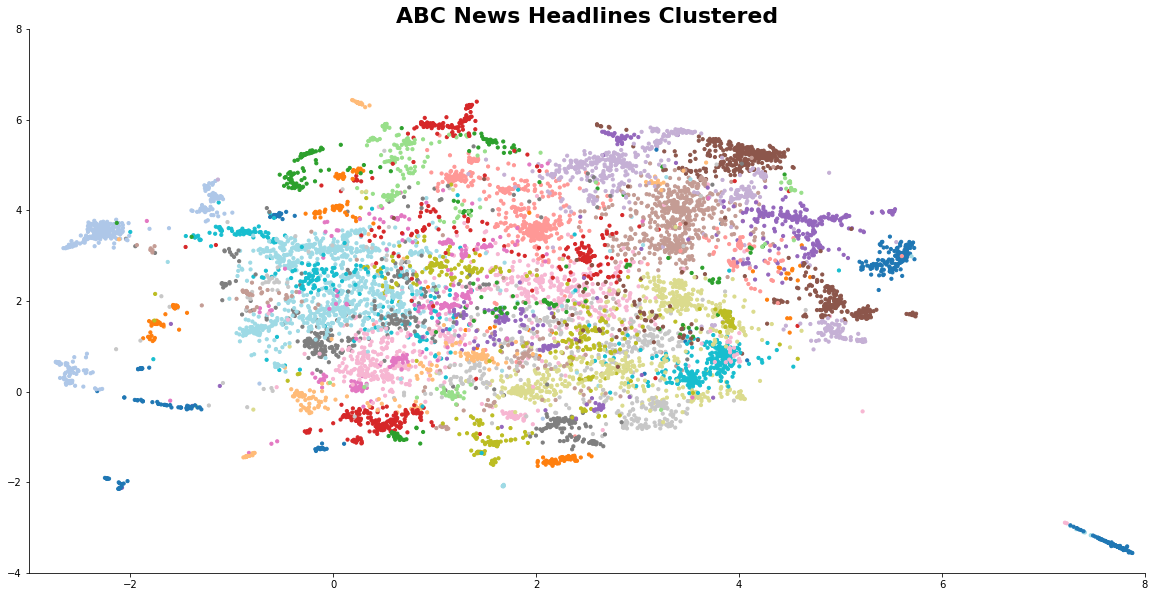

In [22]:
# get 2D umap embeddings to help create visualisation
umap_embedder_2d = umap.UMAP(
        n_neighbors=15, 
        n_components=2,
        min_dist=0.0,
        metric="cosine",
        random_state=1
    ).fit(list(data["headline_sentence_embedding"]))
umap_embeddings_2d = umap_embedder_2d.transform(list(final_df["headline_sentence_embedding"]))
final_df['2d_umap_embeddings'] = umap_embeddings_2d.tolist()
final_df["x_axis_embedding"] = umap_embeddings_2d[:, 0].tolist()
final_df["y_axis_embedding"] = umap_embeddings_2d[:, 1].tolist()

# visualise and set title, colours etc.
figure, axis = plt.subplots()
figure.set_size_inches(20, 10)
axis.set_title(
    f"ABC News Headlines Clustered",
    fontdict={"fontsize": 22, "fontweight": "bold"},
)

plt.scatter(
    final_df["x_axis_embedding"], 
    final_df["y_axis_embedding"], 
    c=final_df["final_cluster"], 
    s=10, 
    cmap='tab20'
)
plt.xlim(-3, 8)
plt.ylim(-4, 8)
# Hide the right and top spines
axis.spines["right"].set_visible(False)
axis.spines["top"].set_visible(False)
plt.show()
# plt.savefig(f"abc_news_headlines_clustered.png", transparent=True)

# Find Similar Headlines using Cosine Similarity

It might be interesting to find past articles similar to a news topic you are interested in. For example we might want to search for headlines related to stock market dips in the past. We can create a headline as a starting point which we will compare all of our headlines with to try and find relevant articles.

In [23]:
def get_closest_articles(headline_for_comparison, embeddings, all_headlines, closest_n=5):
    """
    Returns the closes n headlines to the provided sample headline
    """
    query_embedding = model.encode(headline_for_comparison)
    distances = cosine_similarity([query_embedding], embeddings)[0]
    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1], reverse=True)
    
    return results

In [24]:
sample_article_headline_for_comparison = "Stock market crash on the way"
number_of_similar_headlines_to_show = 5

# we will use cosine similarity to find sample
results = get_closest_articles(sample_article_headline_for_comparison, final_df['headline_sentence_embedding'].tolist(), final_df['headline_text'].tolist(), number_of_similar_headlines_to_show)
print("Sample Article Headline:", sample_article_headline_for_comparison)
print("\nTop 5 most similar headlines in corpus:")
for index, similarity in results[0:number_of_similar_headlines_to_show]:
    print(final_df['headline_text'].tolist()[index].strip(), "(Score: %.2f)" % (similarity))

Sample Article Headline: Stock market crash on the way

Top 5 most similar headlines in corpus:
sharp falls continue on share market (Score: 0.76)
market wrap markets fall before storm (Score: 0.70)
local market down on us bailout uncertainty (Score: 0.62)
monday markets (Score: 0.62)
fatal crash on dukes highway (Score: 0.59)


# Conclusion

- Clustering sentence vectors appears to be a useful method to help gain an understanding of unlabelled text data

- Reducing the demensionality of our sentence vectors helped us avoid the curse of dimensionality and also meant these vectors could be easily stored because of their reduced size

- HDBSCAN is a useful clustering method as the number of clusters does not need to be specified before clustering and it is less prone to noise than DBSCAN as it is high density based

- By labelling our clusters we were able to get an idea of the kind of headlines that commonly occured in ABC news across the last 15 years

- Creating 2D UMAP embeddings allowed us to visualise our clusters

- Cosine similairty is a useful distance metric that can be used to compare the similarity of sentence embeddings

# Additional Code

In [17]:
# # As we are using headlines there won't be many headlines with multiple sentences
# # If you had multiple sentences you could use the pybsd package to split sentences
# import pybsd
# segmenter = pysbd.Segmenter(language='en', clean=False)
# data['headline_text_sentences'] = data['headline_text'].apply(lambda row: segmenter.segment(row))

In [18]:
# # To get data from a database into Pandas use the below code.
# from sqlalchemy import create_engine
# from dotenv import load_dotenv

# load_dotenv()
# QUERY = """
# """
# db_connection_string = f"postgresql://{os.getenv('DATABASE_USER')}:{os.getenv('DATABASE_PASSWORD')}@{os.getenv('DATABASE_REMOTE_BIND_ADDRESS')}:5432/{os.getenv('DATABASE_SCHEMA')}?sslmode=require&sslrootcert=rds.pem"
# engine = create_engine(db_connection_string)

# # load the main SQL data
# data = pd.read_sql_query(QUERY, con=engine)